In [1]:
import os
import numpy as np
import pandas as pd
from collections import OrderedDict, Counter

import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display, Markdown, HTML, clear_output, display_html

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

from src.train import Train

In [2]:
display(Markdown("<h2>Book Reviews Sentiment Analysis</h2>"))
loading_section       = ["Prepare Model Data"]
sections              = ["Train", "Evaluation"]
conclusion_section    = ["Summary"]

train_sub_section   = ["Ensemble Model", "LSTM", "BERT"]
me_sub_section      = ["Model Performance", "Model Interpretability"]

accordions = OrderedDict()
accordions["** Loading **"] = widgets.Accordion(children=[widgets.Output() for section in loading_section])
[accordions["** Loading **"].set_title(i, section) for i, section in enumerate(loading_section)]

for section in sections:
    if section == "Train":
        accordions[section] = widgets.Accordion(children=[widgets.Output() for sub_section in train_sub_section])
        [accordions[section].set_title(i, sub_section) for i, sub_section in enumerate(train_sub_section)]
    else:
        accordions[section] = widgets.Accordion(children=[widgets.Output() for sub_section in me_sub_section])
        [accordions[section].set_title(i, sub_section) for i, sub_section in enumerate(me_sub_section)]
        
accordions["** Conclusion **"] = widgets.Accordion(children=[widgets.Output() for section in conclusion_section])
[accordions["** Conclusion **"].set_title(i, section) for i, section in enumerate(conclusion_section)]
        
widget_fields = widgets.Tab(children=[accordions[t] for t in accordions])
[widget_fields.set_title(i, sub) for i, sub in enumerate(accordions.keys())]

<h2>Book Reviews Sentiment Analysis</h2>

[None, None, None, None]

In [3]:
widget_fields

In [4]:
train = Train()
self = train

RANDOM_SEED = 42
np.random.seed(train.MODELLING_CONFIG["RANDOM_SEED"])
torch.manual_seed(train.MODELLING_CONFIG["RANDOM_SEED"])

In [5]:
%matplotlib agg

with accordions["** Loading **"].children[0]:
    clear_output()
    display(Markdown("<h2> Initiating Modelling Data Preparation ... </h2>"))
    train.prepare_model_data()

    display(train.histogram_plot(xvar=train.token_lens, 
                                 xlabel="Token count: Most of the reviews seem to contain less than 128 tokens, to be on the safe side and choose a maximum length of 160."))

In [8]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"

# # load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [35]:
token_lens = []

for txt in train.data["reviews_abt"]["reviews"]:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

In [36]:
pd.DataFrame(Counter(token_lens), index=[0]).T.reset_index().rename(columns={"index":"length", 0:"count"}).sort_values("count", ascending=False)

,length,count
0,512,18505
21,8,2161
65,6,2154
158,7,2129
85,9,2096
...,...,...
489,496,30
490,501,28
209,473,28
366,471,27


In [32]:
def histogram_plot(xvar, xlabel, title=None):
    fig, ax = plt.subplots(figsize=(15,4))
    sns.histplot(x=xvar, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_title(title, fontisize=12, weight="bold")
    
    return fig

In [ ]:
histogram_plot(xvar=token_lens, 
               xlabel="Token count: Most of the reviews seem to contain less than 128 tokens, to be on the safe side and choose a maximum length of 160.")

Text(0.5, 0, 'Token count: Most of the reviews seem to contain less than 128 tokens, to be on the safe side and choose a maximum length of 160.')

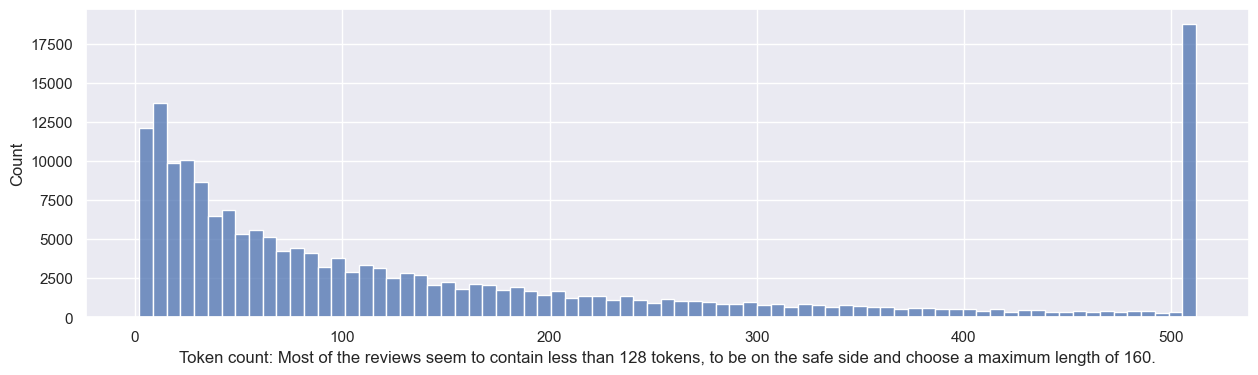

In [20]:
fig, ax = plt.subplots(figsize=(15,4))
sns.histplot(x=token_lens, ax=ax)
ax.set_xlabel("""Token count: Most of the reviews seem to contain less than 128 tokens, to be on the safe side and choose a maximum length of 160.""")

In [39]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    
    def __len__(self):
        return len(self.reviews)
    
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(review,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors="pt",
                                              )

        return {
            "review_text": review,
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype=torch.long)
            }


def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(reviews=df.content.to_numpy(), targets=df.sentiment.to_numpy(), tokenizer=tokenizer, max_len=max_len)

    return DataLoader(ds, batch_size=batch_size, num_workers=4)

In [ ]:
self.logger.info("  creating train, test data on ratio & test, validate data on ratio {}...".format(self.MODELLING_CONFIG["TEST_SPLIT_RATIO"], self.MODELLING_CONFIG["VALIDATE_SPLIT_RATIO"]))
self.data["train_df"], self.data["test_df"] = train_test_split(self.data["reviews_abt"], test_size=self.MODELLING_CONFIG["TEST_SPLIT_RATIO"], random_state=self.MODELLING_CONFIG["RANDOM_SEED"])
self.data["val_df"], self.data["test_df"] = train_test_split(df_test, test_size=self.MODELLING_CONFIG["VALIDATE_SPLIT_RATIO"], random_state=self.MODELLING_CONFIG["RANDOM_SEED"])

In [ ]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)